In [1]:
########################################################################

# import the necessary packages
import cv2
import numpy as np
import argparse
import imutils
import cv2
import matplotlib.pyplot as plt
# import torch
# import torchvision.transforms as T

from IPython.display import display, Image
from easydict import EasyDict
from scipy.spatial import distance as dist
from imutils import perspective
from imutils import contours
# from torchvision import models
# fcn  = models.segmentation.fcn_resnet101(pretrained=True, progress=True, num_classes=21, aux_loss=None).eval()
# dlab = models.segmentation.deeplabv3_resnet101(pretrained=True, progress=True, num_classes=21, aux_loss=None).eval()
# from PIL import Image as PILImage
 
## construct the argument parse and parse the arguments
#ap = argparse.ArgumentParser()
#ap.add_argument("-i", "--image", required=False, help="path to the input image")
#ap.add_argument("-w", "--width", type=float, required=False, help="width of the left-most object in the image (in inches)")
## Do args = vars(ap.parse_args() in Jupyter
#args = EasyDict({
#    "image": 10,
#    "width": 10
#})

########################################################################

In [2]:
### DECLARE GENERAL FUNCTIONS
def midpoint(ptA, ptB):
    return ((ptA[0] + ptB[0]) * 0.5, (ptA[1] + ptB[1]) * 0.5)

def order_points(pts):
    # sort the points based on their x-coordinates
    xSorted = pts[np.argsort(pts[:, 0]), :]
    
    # grab the left-most and right-most points from the sorted
    # x-roodinate points
    leftMost = xSorted[:2, :]
    rightMost = xSorted[2:, :]
    
    # now, sort the left-most coordinates according to their
    # y-coordinates so we can grab the top-left and bottom-left
    # points, respectively
    leftMost = leftMost[np.argsort(leftMost[:, 1]), :]
    (tl, bl) = leftMost
    
    # now that we have the top-left coordinate, use it as an
    # anchor to calculate the Euclidean distance between the
    # top-left and right-most points; by the Pythagorean
    # theorem, the point with the largest distance will be
    # our bottom-right point
    D = dist.cdist(tl[np.newaxis], rightMost, "euclidean")[0]
    (br, tr) = rightMost[np.argsort(D)[::-1], :]
    
    # return the coordinates in top-left, top-right,
    # bottom-right, and bottom-left order
    return np.array([tl, tr, br, bl], dtype="float32")

In [3]:
def measureImg(imgname_, fineTuning, edgeType, minObjArea, invertPimg, cannyThreshold=[50, 100], binThresh=128, denoise=0):
    ''' <required> imgname_ : 'path + image file name' as a string of the image to analyze
    
        <required> fineTuning : parameter used to adjust the "pixels per metric", the purpose is to
                                tune this value to match the dimensions of the refetence object
        
        <required> edgeType : can be 'edged', 'dilated', or 'eroded' as a string
                              'edged'   : performs the Canny edge detection algorithm
                              'dilated' : performs 'edged' and increases the object area to accentuate
                                          features
                              'eroded'  : performs 'dilated' and erodes away the boundaries of
                                          foreground object to diminish the features of an image
        
        <required> minObjArea : defines the minimum object size to be analyzed, ignore the object if
                                the contour is not sufficiently large
        
        <required> invertPimg : Boolean
                                True  : implements a binary version of the original image before the
                                        detection algorithm
                                False : implements a grey-scale version of the original image before
                                        the detection algorithm
        
        <optional> cannyThreshold=[50, 100] : only useful if invertPimg=False [minVal, maxVal]
                                              any edges with intensity gradient more than maxVal are
                                              sure to be edges and those below minVal are sure to be
                                              non-edges, so discarded.
        
        <optional> binThresh=128 : only useful if invertPimg=True
                                   defines a threshold when creating a binary image, 128 is the middle
                                   of black and white in grey scale '''
    
    #TUNE fineTuning TO MATCH THE REFERENCE OBJECT

    ### IMAGE PRE-PROCESSING
    # load the image
    img = cv2.imread(imgname_)
    
    # Image Denoising
    dst = cv2.fastNlMeansDenoisingColored(
        src=img,
        dst=None,
        h=denoise,
        hColor=denoise,
        templateWindowSize=7,
        searchWindowSize=21)

    # Convert to grayscale
    grey = cv2.cvtColor(dst, cv2.COLOR_BGR2GRAY)

    # define a threshold, 128 is the middle of black and white in grey scale
    thresh = binThresh #256/2

    # assign blue channel to zeros
    binary = cv2.threshold(grey, thresh, 256, cv2.THRESH_BINARY)[1]

#     # Inverting the colors
#     invert = abs(255 - binary)
    
    ### IMAGE PROCESSING
    # perform edge detection, then perform a dilation + erosion to
    
    # close gaps in between object edges
    if invertPimg == False:
        edged = cv2.Canny(grey, cannyThreshold[0], cannyThreshold[1])
    else:
        edged = cv2.Canny(binary, cannyThreshold[0], cannyThreshold[1])

    dilated = cv2.dilate(edged, None, iterations=1)
    eroded = cv2.erode(dilated, None, iterations=1)

    if edgeType == "dilated":
        Pimg = dilated
    elif edgeType == "eroded":
        Pimg = eroded
    else:
        Pimg = edged
    
    # Show and save image
    print()
    print('Image to Process:')
    imgname='./img_out.png'
    cv2.imwrite(imgname,Pimg)
    display(Image(filename=imgname))
    
    ### GET IMAGE MEASUREMENTS
    # find contours in the edge map
    cnts = cv2.findContours(Pimg.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)

    # sort the contours from left-to-right and initialize the
    # 'pixels per metric' calibration variable
    (cnts, _) = contours.sort_contours(cnts)
    pixelsPerMetric = None

    # loop over the contours individually
    i = 0
    for c in reversed(cnts):
        # if the contour is not sufficiently large, ignore it
        if cv2.contourArea(c) < minObjArea:
            continue

        # compute the rotated bounding box of the contour
        orig = img.copy()
        box = cv2.minAreaRect(c)        
        box = cv2.cv.BoxPoints(box) if imutils.is_cv2() else cv2.boxPoints(box)
        box = np.array(box, dtype="int")

        # order the points in the contour such that they appear
        # in top-left, top-right, bottom-right, and bottom-left
        # order, then draw the outline of the rotated bounding
        # box
        box = perspective.order_points(box)
        cv2.drawContours(orig, [box.astype("int")], -1, (0, 255, 0), 1)

        # loop over the original points and draw them
        for (x, y) in box:
            cv2.circle(orig, (int(x), int(y)), 2, (0, 0, 255), -1)

        # unpack the ordered bounding box, then compute the midpoint
        # between the top-left and top-right coordinates, followed by
        # the midpoint between bottom-left and bottom-right coordinates
        (tl, tr, br, bl) = box
#         print(box, '\n', order_points(box))
#         (tl, tr, br, bl) = order_points(box)
        (tltrX, tltrY) = midpoint(tl, tr)
        (blbrX, blbrY) = midpoint(bl, br)

        # compute the midpoint between the top-left and top-right points,
        # followed by the midpoint between the top-righ and bottom-right
        (tlblX, tlblY) = midpoint(tl, bl)
        (trbrX, trbrY) = midpoint(tr, br)

        # draw the midpoints on the image
        cv2.circle(orig, (int(tltrX), int(tltrY)), 2, (255, 0, 0), -1)
        cv2.circle(orig, (int(blbrX), int(blbrY)), 2, (255, 0, 0), -1)
        cv2.circle(orig, (int(tlblX), int(tlblY)), 2, (255, 0, 0), -1)
        cv2.circle(orig, (int(trbrX), int(trbrY)), 2, (255, 0, 0), -1)

        # draw lines between the midpoints
        cv2.line(orig, (int(tltrX), int(tltrY)), (int(blbrX), int(blbrY)), (255, 0, 255), 1)
        cv2.line(orig, (int(tlblX), int(tlblY)), (int(trbrX), int(trbrY)), (255, 0, 255), 1)

        # compute the Euclidean distance between the midpoints
        dA = dist.euclidean((tltrX, tltrY), (blbrX, blbrY))
        dB = dist.euclidean((tlblX, tlblY), (trbrX, trbrY))

        # if the pixels per metric has not been initialized, then
        # compute it as the ratio of pixels to supplied metric
        # (in this case, inches)
        if pixelsPerMetric is None:
            pixelsPerMetric = dB / fineTuning

        # compute the size of the object
        dimA = dA / pixelsPerMetric
        dimB = dB / pixelsPerMetric

        # convert inches to nm
        dimA = dimA*25400000
        dimB = dimB*25400000
        
        # draw the object sizes on the image
        txtcolor=(255, 171, 0)
        cv2.putText(orig, "{:.2f}nm".format(dimB),
                    (int(tltrX - 15), int(tltrY - 10)), cv2.FONT_HERSHEY_SIMPLEX,
                    0.6, txtcolor, 2, 5)
        cv2.putText(orig, "{:.2f}nm".format(dimA),
                    (int(trbrX + 10), int(trbrY)), cv2.FONT_HERSHEY_SIMPLEX,
                    0.6, txtcolor, 2)

        # Show and save output image
        print()
        print('Measurements in progress ... ' + str(i))
        print('dimX=' + str(round(dimB,2)) + 'nm;  dimY=' + str(round(dimA,2)) + 'nm;')
        imgname='./img/img_out.png'
        cv2.imwrite(imgname,orig)
        display(Image(filename=imgname))
        i += 1

In [ ]:
help(measureImg)
display(Image(filename='./img/UScoinRef.png'))
measureImg('./img/example_01.png', 0.9966449845, 'eroded', 100, False, cannyThreshold=[40, 250])

In [ ]:
measureImg('./img/F4a_Lei2015.png', 0.0335260826, 'canny', 250, True, binThresh=200)

In [ ]:
measureImg('./img/F4a_nc_Lei2015.png', 0.01656043, 'canny', 250, False, cannyThreshold=[50, 100])

In [ ]:
measureImg('./img/F4b_nc_Lei2015.png', 0.0393700786, 'canny', 150, False, cannyThreshold=[50, 100])


Image to Process:


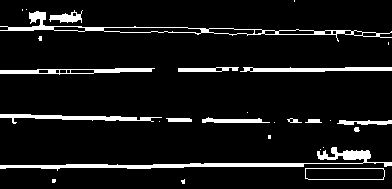


Measurements in progress ... 0
dimX=341772.15nm;  dimY=25316.46nm;


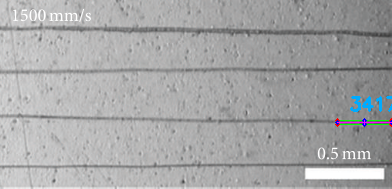


Measurements in progress ... 1
dimX=101265.82nm;  dimY=18987.34nm;


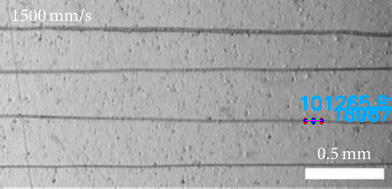


Measurements in progress ... 2
dimX=500000.0nm;  dimY=69620.25nm;


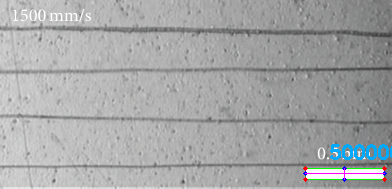


Measurements in progress ... 3
dimX=88607.59nm;  dimY=25316.46nm;


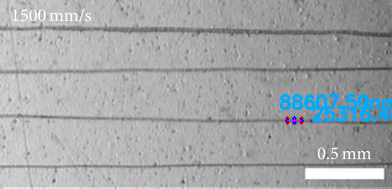


Measurements in progress ... 4
dimX=955696.2nm;  dimY=25316.46nm;


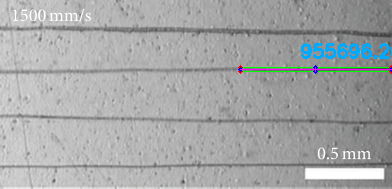


Measurements in progress ... 5
dimX=424050.63nm;  dimY=31645.57nm;


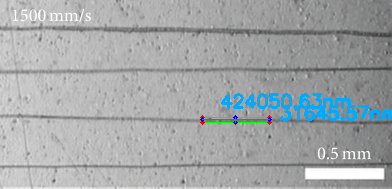


Measurements in progress ... 6
dimX=379746.83nm;  dimY=25316.46nm;


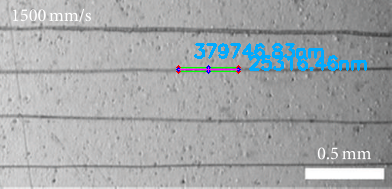


Measurements in progress ... 7
dimX=158227.85nm;  dimY=18987.34nm;


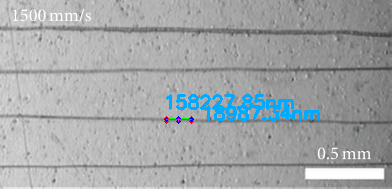


Measurements in progress ... 8
dimX=208860.76nm;  dimY=75949.37nm;


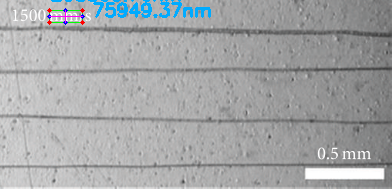


Measurements in progress ... 9
dimX=2472888.15nm;  dimY=126621.83nm;


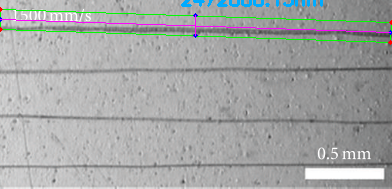


Measurements in progress ... 10
dimX=971601.45nm;  dimY=31803.4nm;


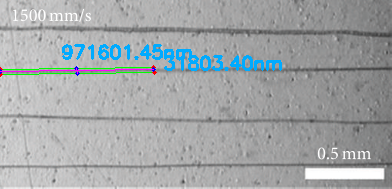


Measurements in progress ... 11
dimX=1018987.34nm;  dimY=56962.03nm;


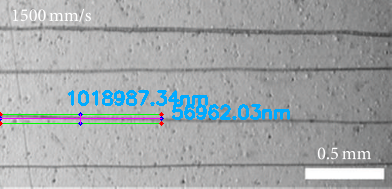


Measurements in progress ... 12
dimX=2471721.57nm;  dimY=120294.8nm;


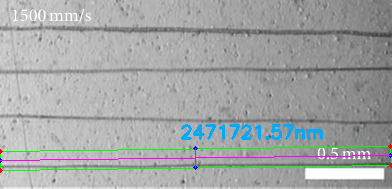

In [4]:
measureImg('./img/Zheng_00.png', 0.0134555965, 'eroded', 25, False, cannyThreshold=[40, 40], denoise=10)